# Evolução de Galaxias em Aglomerados

In [1]:
import numpy as np

import astropy.io.ascii as at
from astropy.io.fits import getdata
from astropy.table import Table, vstack
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM

import scipy.stats as stats
import scipy.integrate as integrate
import seaborn as sns
import matplotlib.pyplot as plt

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
Mpc2cm = 3.086e+27

sns.set_style("whitegrid")
sns.set_context('paper', font_scale=1.5)
# plt.style.use('fivethirtyeight')

### Dados

In [2]:
## get the data
root = "../"

file_gal = root+"catalogos/galaxias/master_DES_SDSS_agn.fits"      ## All SDSS galaxies on the cluster FOV
file_cls = root+"catalogos/aglomerados/master_DES_SDSS.fits"

g = Table(getdata(file_gal))
cat = Table(getdata(file_cls))

# maskSDSS, mask_DES = (g['MEM_MATCH_ID']==999999), (g['jid']==16959)
# g[maskSDSS] = g[maskSDSS]['mr']<22.2
# g[maskDES] = g[maskDES]['mi']<22.9

# g['type'] = g['type']*g['Pz']

### Novas Colunas

#### Cor

In [3]:
g['g-r'] = g['mg']-g['mr']
g['r-i'] = g['mr']-g['mi']
g['i-z'] = g['mi']-g['mz']

In [4]:
col = ['gr','ri','iz']

lb = ['Ptype_%s'%(lc) for lc in col]
lb1 = ['Pztype_%s'%(lc) for lc in col]

for l,l1,c in zip(lb,lb1,col):
    g[l] = g['type_'+c]*g['Pmem']
    g[l1] = g['type_'+c]*g['Pz']
    

g['type']=(g['Pztype_gr']+g['Pztype_ri']+g['Pztype_iz'])/3

p1,p2= g['Pztype_gr'],g['Pztype_ri']
pt = (p1+p2)/2
g['type1'] = np.where((p1*p2!=0)&(pt==0),(p1/2),pt)

p1,p2= g['Pztype_ri'],g['Pztype_iz']
pt = (p1+p2)/2
g['type2'] = np.where((p1*p2!=0)&(pt==0),(p1/2),pt)

#### Probabilidae Cor

In [5]:
Pred = (1)*(np.where(g['type_gr']>0,1,0)+
              np.where(g['type_ri']>0,1,0)+
              np.where(g['type_iz']>0,1,0))
              
Pblue = (1)*(np.where(g['type_gr']<0,1,0)+
               np.where(g['type_ri']<0,1,0)+
               np.where(g['type_iz']<0,1,0))
g['Pred'] = Pred
g['Pblue'] = Pblue

In [6]:
def getIDX(data,idx):
    id0 = np.empty(0,dtype=int)
    for i in idx:
        w, = np.where(data['z_cls']==i)
        id0 = np.append(id0,w)
    return id0

In [7]:
print('a) retirando aglomerados com algum defeito')
    
#### Filter GC at redshift bin (z<0.35)
mask =  np.where(cat['FLAG']==False)

id_cut_cls = cat['redshift'][mask]
id_cut_gal = getIDX(g,id_cut_cls)

cat = cat[mask]
g = g[id_cut_gal]

a) retirando aglomerados com algum defeito


In [8]:
print('b) limitando amostra a z < 0.6 ')
    
#### Filter GC at redshift bin (z<0.35)
mask = (cat['redshift']<=0.65) & (cat['redshift']>=0.1)
# mask = (cat['redshift']>=0.2) & (cat['SDSS'] == True) & (cat['redshift']<=0.4) 

id_cut_cls = cat['redshift'][mask]
id_cut_gal = getIDX(g,id_cut_cls)

catc = cat[mask]
gc = g[id_cut_gal]

b) limitando amostra a z < 0.6 


### Aglomerado Cool-Core e Relaxados

In [9]:
cool_core = (cat['CC']==True)
rel = (cat['Rel'] == True)

id_CC_gal = getIDX(g,cat['redshift'][cool_core])
id_R_gal = getIDX(g,cat['redshift'][(rel)])

g['Rel'] = False
g['CC'] = False

g['CC'][id_CC_gal] = True
g['Rel'][id_R_gal] = True

## Funções

In [10]:
save='../results/27Jun/'
## Frações de datas
def fracaoRedBlue(data,bin_width=0.10,col='Rnorm',label='type_ri'):
    bin1 = np.trunc(g[col]/bin_width)
    data_bin = g.group_by(bin1)

    xbin = (data_bin.groups.keys+1/2)*bin_width ## xbins
    red_plus_blue = data_bin[label].groups.aggregate(np.count_nonzero)
    red_minus_blue = data_bin[label].groups.aggregate(np.sum)

    red = (red_plus_blue+red_minus_blue)/2
    blue = (red_plus_blue-red_minus_blue)/2

    bkg_mask,member_mask = xbin>=6, xbin<=4
    red_bkg = red[bkg_mask].sum()
    blue_bkg = blue[bkg_mask].sum()

    area_per_bin = np.pi*(xbin[1]-xbin[0])**2
    area_bkg = np.pi*(np.max(xbin[bkg_mask])**2-np.min(xbin[bkg_mask])**2)
    gamma = area_per_bin/area_bkg

    red_net = (red-gamma*red_bkg)[member_mask]
    blue_net = (blue-gamma*blue_bkg)[member_mask]
    Total = (red_net+blue_net)

    fred = red_net/Total
    fblue = blue_net/Total
    return fred, fblue, red_net, blue_net, xbin[member_mask]

def poissonError(Nred,Nblue):
    A = ( np.sqrt(Nred)/(Nred+Nblue) + Nred/(Nred+Nblue)**(3/2) )
    B = ( np.sqrt(Nblue)/(Nred+Nblue) + Nblue/(Nred+Nblue)**(3/2) )
    return A,B

def plotFraction(gc,bin_width=0.25,title=None,label='type_ri',col='Rnorm',xlabel=r'$R \; [R_{500}] $'):
    
    fred,fblue,Nred,Nblue,radii = fracaoRedBlue(gc,bin_width=bin_width,col=col,label=label)
    
    erry_red, erry_blue = poissonError(Nred,Nblue)
#     erry_red, erry_blue = 0.01,0.01
    plt.clf()
    plt.figure(figsize=(12,8))
    if col=='Rnorm':
        plt.axvline(1/0.65,linestyle='--',color='k',label=r'$R_{200,c}$')
    plt.errorbar(radii,fred,xerr=bin_width/2,yerr=erry_red,marker='o',color='#800000',label=r'$f_{red}$')
    plt.errorbar(radii,fblue,xerr=bin_width/2,yerr=erry_blue,marker='o',color='#000080',label=r'$f_{blue}$')
#     plt.xlim(0,radii.max()+bin_width/2)
    plt.legend()
    plt.ylabel('Fração')
#     plt.xlabel(r'$R \; [Mpc]$')
    plt.xlabel(xlabel)
#     plt.ylim(0.,1.)
    if title is not None:
        plt.title(title)

## Dressler Relation

In [ ]:
color = ['(g - r)','(r- i)','(i - z)']
col = ['gr','ri','iz']

bin1 = (g['z_cls']<=0.35)&(g['Pz']>0.1)&(g['Mr']<=-19.8)
print('# galaxias',np.count_nonzero(bin1))
print('# Aglomerados',len(np.unique(g[bin1]['Name'])))

for l1, c1 in zip(col,color):
    plotFraction(g[bin1],title=r'Amostra Xmatcha e M12: $0.1 < z \leq 0.35$',
                 bin_width=0.25,label='Pztype_%s'%(l1))
    plt.figtext(0.7,0.15,'cor: %s'%(c1),size=24)
    plt.ylim(0.2,0.8)
    plt.xlim(0.,4.)
    plt.savefig(save+'figure_bin1_Pz_%s.png'%(l1))

# galaxias 346995
# Aglomerados 62


In [ ]:
color = ['(g - r)','(r- i)','(i - z)']
col = ['gr','ri','iz']

bin1 = (g['z_cls']>0.35)&(g['Pz']>0.1)&(g['Mr']<=-19.8)
print('# galaxias',np.count_nonzero(bin1))
print('# Aglomerados',len(np.unique(g[bin1]['Name'])))

for l1, c1 in zip(col,color):
    plotFraction(g[bin1],title=r'Amostra Xmatcha: $0.35 < z \leq 0.66$',
                 bin_width=0.25,label='Pztype_%s'%(l1))
    plt.figtext(0.7,0.15,'cor: %s'%(c1),size=24)
    plt.ylim(0.2,0.8)
    plt.xlim(0.,4.)
    plt.savefig(save+'figure_bin2_Pz_%s.png'%(l1))

## Aglomerados Cool-Core

In [ ]:
g['csb'] = 0.
g['w'] = 0.
for i in range(len(cat)):
    cls_id, cls_z, M500, Mg500 = cat['redshift'][i],cat['redshift'][i],(cat['M500'][i]),cat['Mg500'][i]
    csb,w=cat['csb'][i],cat['w'][i]
    title = '%s'%(cat['Name'][i])

    galaxies = g[g['z_cls']==cls_id]
    maskAll, = np.where(g['z_cls'] == cls_id)
    g['csb'][maskAll] = csb
    g['w'][maskAll] = w

In [28]:
## Frações de datas
def fracaoRedBlue2(data,bin_width=0.10,r_aper=1,col='csb',label='type_ri'):
    '''For non radii variables
    '''
    gm,gb = data[data['Rnorm']<=r_aper],data[data['Rnorm']>=6]
    r_out = np.max(data['Rnorm'])
    
    bin1 = np.trunc(gm[col]/bin_width)
    data_bin = gm.group_by(bin1)

    xbin = (data_bin.groups.keys+1/2)*bin_width ## xbins
    red_plus_blue = data_bin[label].groups.aggregate(np.count_nonzero)
    red_minus_blue = data_bin[label].groups.aggregate(np.sum)

    red = (red_plus_blue+red_minus_blue)/2
    blue = (red_plus_blue-red_minus_blue)/2
    
    ## Background Subtraction
    area_per_bin = np.pi*(r_aper)**2
    area_bkg = np.pi*(r_out**2-6**2)
    gamma = area_per_bin/area_bkg
    
    bin_bkg = np.trunc(gb[col]/bin_width)
    data_bin_bkg = gb.group_by(bin_bkg)

    red_plus_blue = data_bin_bkg[label].groups.aggregate(np.count_nonzero)
    red_minus_blue = data_bin_bkg[label].groups.aggregate(np.sum)

    red_bkg = (red_plus_blue+red_minus_blue)/2
    blue_bkg = (red_plus_blue-red_minus_blue)/2
    
    red_net = (red-gamma*red_bkg)
    blue_net = (blue-gamma*blue_bkg)
    Total = (red_net+blue_net)

    fred = red_net/Total
    fblue = blue_net/Total
    return fred, fblue, red_net, blue_net, xbin

In [29]:
def plotFraction2(gc,bin_width=0.25,title=None,r_aper=1,label='type_ri',col='csb',xlabel=r'$c_{sb} $'):
    fred,fblue,Nred,Nblue,radii = fracaoRedBlue2(gc,r_aper=r_aper,bin_width=bin_width,
                                                 col=col,label=label)
    
    erry_red, erry_blue = poissonError(Nred,Nblue)
    
    plt.figure(figsize=(12,8))
    plt.errorbar(radii,fred,xerr=bin_width/2,yerr=erry_red,marker='o',color='#800000',label=r'$f_{red}$')
    plt.errorbar(radii,fblue,xerr=bin_width/2,yerr=erry_blue,marker='o',color='#000080',label=r'$f_{blue}$')
    plt.legend()
    plt.ylabel('Fração')
    plt.xlabel(xlabel)
    if title is not None:
        plt.title(title)
        
def plot2Fraction(g1,g2,lb1='bla',lb2='bla',bin_width=0.25,title=None,label='type'):
    fred_1,fblue_1,Nred_1,Nblue_1,radii = fracaoRedBlue(g1,bin_width=bin_width,label=label)
    fred_2,fblue_2,Nred_2,Nblue_2,radii = fracaoRedBlue(g2,bin_width=bin_width,label=label)
    
    erry_red1, erry_blue1 = poissonError(Nred_1,Nblue_1)
    erry_red2, erry_blue2 = poissonError(Nred_2,Nblue_2)
    
    plt.figure(figsize=(12,10))
    plt.axvline(1/0.65,linestyle='--',color='k',label=r'$R_{200,c}$')
    plt.errorbar(radii,fred_1,xerr=bin_width/2,yerr=erry_red1,marker='o',color='#800000',label=r'$f_{red,%s}$'%(lb1))
    plt.errorbar(radii,fblue_1,xerr=bin_width/2,yerr=erry_blue1,marker='o',color='#00008B',label=r'$f_{blue,%s}$'%(lb1))
    
    plt.errorbar(radii,fred_2,xerr=bin_width/2,yerr=erry_red2
                 ,marker='o',color='#C0392B',label=r'$f_{red,%s}$'%(lb2))
    
    plt.errorbar(radii,fblue_2,xerr=bin_width/2,yerr=erry_blue2
                 ,marker='o',color='#5499C7',label=r'$f_{blue,%s}$'%(lb2))
#     plt.axhline(0.5,linestyle='--',color='k')

    #     plt.xlim(0,radii.max()+bin_width/2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Fração')
    plt.xlabel(r'$R/R_{500}$')
    if title is not None:
        plt.title(title)

# galaxias 234253 146544
# aglomerados CC, NCC: 29 33


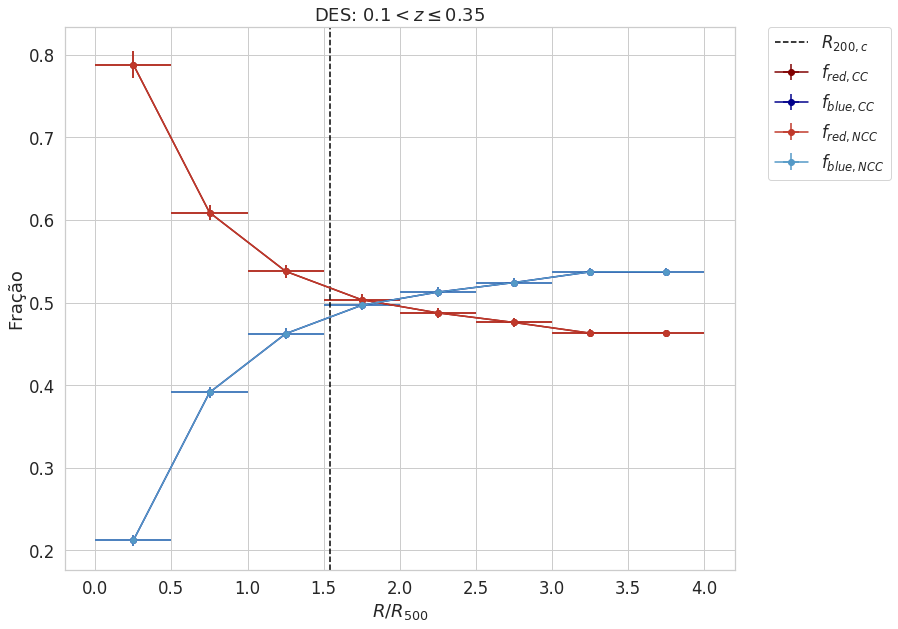

In [30]:
cc1 = (g['z_cls']<=0.35)&(g['Pz']>0.3)&(g['Mr']<=-19.5)&(g['CC']==True)#&(g['DES']==True)
ncc1 = (g['z_cls']<=0.35)&(g['Pz']>0.3)&(g['Mr']<=-19.5)&(g['CC']==False)#&(g['DES']==True)
plot2Fraction(g[cc1],g[ncc1],lb1='CC',lb2='NCC',title=r'DES: $0.1 < z \leq 0.35$',bin_width=0.5,label='Pztype_ri')

print('# galaxias',np.count_nonzero(cc1),np.count_nonzero(ncc1))
print('# aglomerados CC, NCC:',len(np.unique(g[cc1]['Name'])),len(np.unique(g[ncc1]['Name'])))

# galaxias 85243 72380
# aglomerados CC, NCC: 18 16


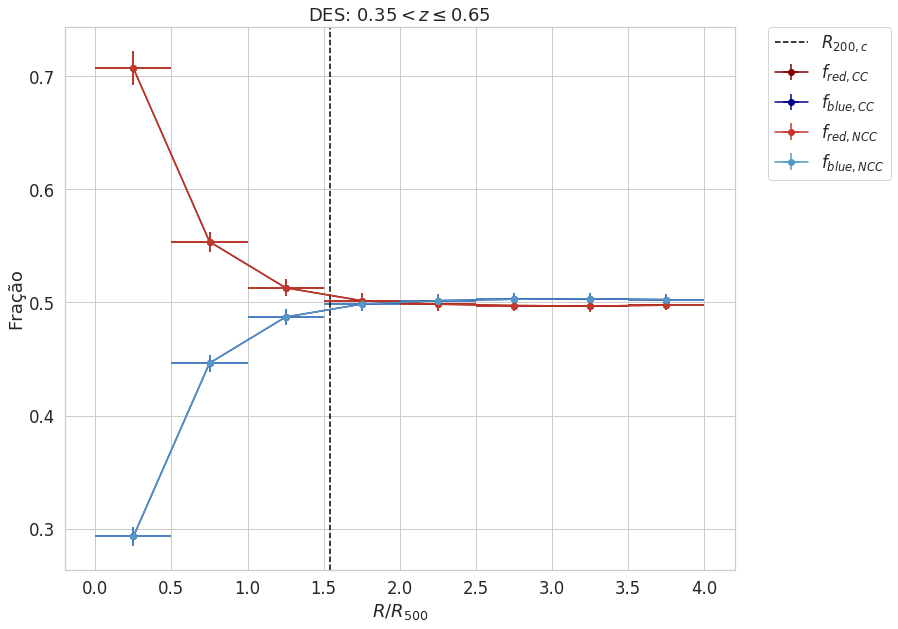

In [31]:
cc2 = (g['z_cls']>0.35)&(g['Pz']>0.3)&(g['DES']==True)&(g['Mr']<=-19.5)&(g['CC']==True)
ncc2 = (g['z_cls']>0.35)&(g['Pz']>0.3)&(g['DES']==True)&(g['Mr']<=-19.5)&(g['CC']==False)
plot2Fraction(g[cc2],g[ncc2],lb1='CC',lb2='NCC',
              title=r'DES: $0.35 < z \leq 0.65$',bin_width=0.5,label='Ptype_ri')

print('# galaxias',np.count_nonzero(cc2),np.count_nonzero(ncc2))
print('# aglomerados CC, NCC:',len(np.unique(g[cc2]['Name'])),len(np.unique(g[ncc2]['Name'])))

## Aglomerados Relaxados

# galaxias 234253 146544
# aglomerados Rel, Nrel: 31 31


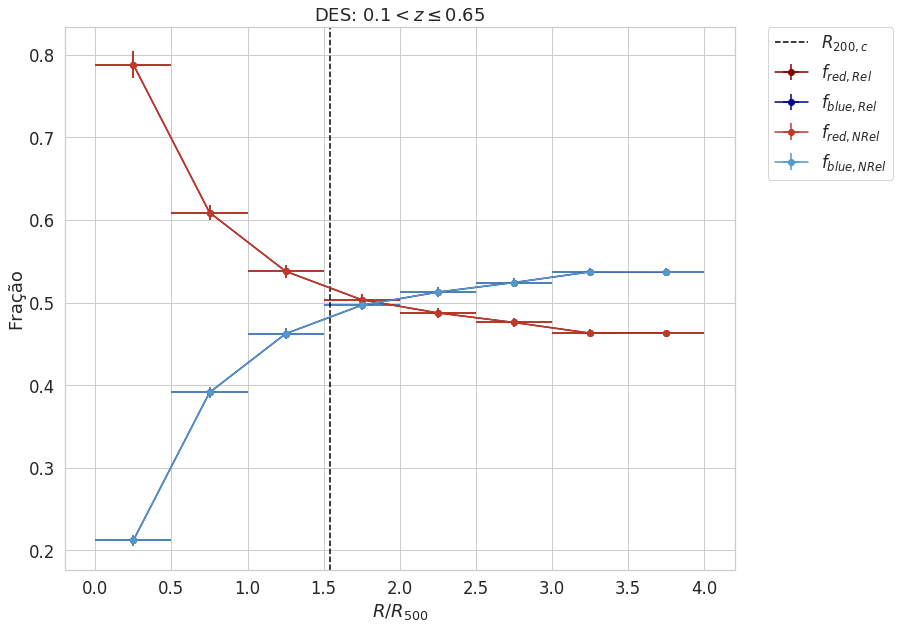

In [32]:
rel1 = (g['Pz']>0.3)&(g['DES']==True)&(g['Mr']<=-19.5)&(g['Rel']==True)
nrel1 =(g['Pz']>0.3)&(g['DES']==True)&(g['Mr']<=-19.5)&(g['Rel']==False)
plot2Fraction(g[rel1],g[nrel1],lb1='Rel',lb2='NRel',
              title=r'DES: $0.1 < z \leq 0.65$',bin_width=0.5,label='Pztype_ri')

print('# galaxias',np.count_nonzero(cc1),np.count_nonzero(ncc1))
print('# aglomerados Rel, Nrel:',len(np.unique(g[rel1]['Name'])),len(np.unique(g[nrel1]['Name'])))

# galaxias 234253 146544
# aglomerados Rel, Nrel: 24 10


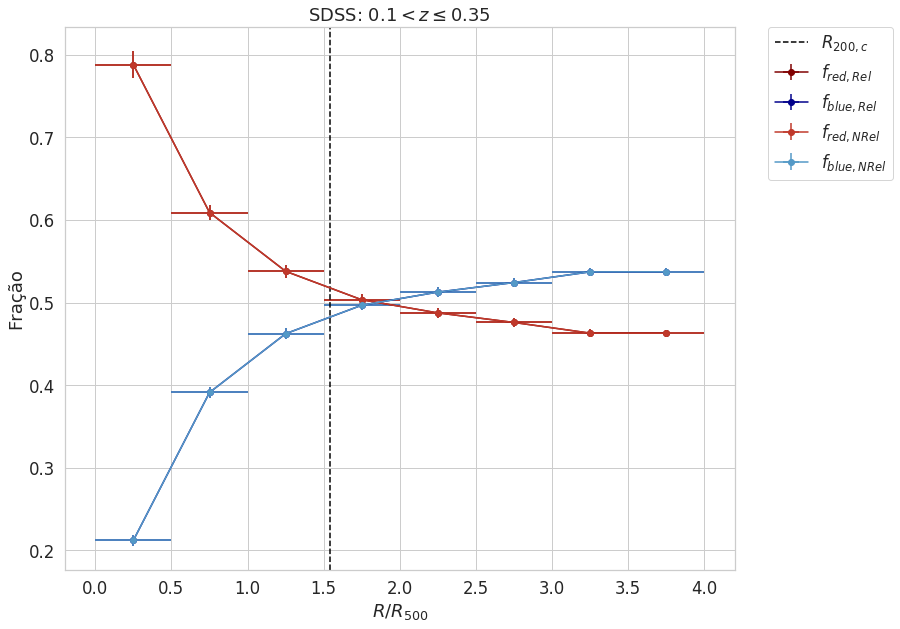

In [33]:
rel1 = (g['Pz']>0.3)&(g['DES']==False)&(g['Mr']<=-19.5)&(g['Rel']==True)
nrel1 =(g['Pz']>0.3)&(g['DES']==False)&(g['Mr']<=-19.5)&(g['Rel']==False)

print('# galaxias',np.count_nonzero(cc1),np.count_nonzero(ncc1))
print('# aglomerados Rel, Nrel:',len(np.unique(g[rel1]['Name'])),len(np.unique(g[nrel1]['Name'])))

plot2Fraction(g[rel1],g[nrel1],lb1='Rel',lb2='NRel',
              title=r'SDSS: $0.1 < z \leq 0.35$',bin_width=0.5,label='Pztype_ri')


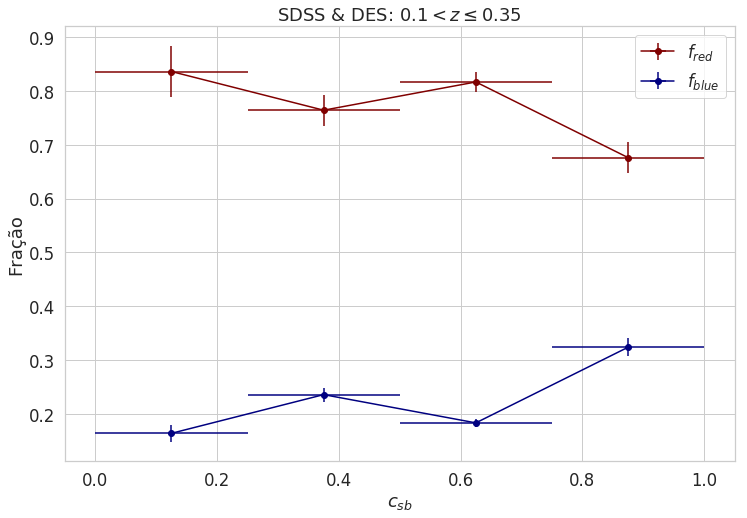

In [34]:
bin1 = (g['Pz']>0.3)&(g['Mr']<=-19.5)&(g['z_cls']<=0.35)
plotFraction2(g[bin1],title=r'SDSS & DES: $0.1 < z \leq 0.35$',bin_width=0.25,r_aper=1,
             xlabel=r'$c_{sb}$',label='Pztype_ri',col='csb')
# plt.savefig('../coolCore_color.png')

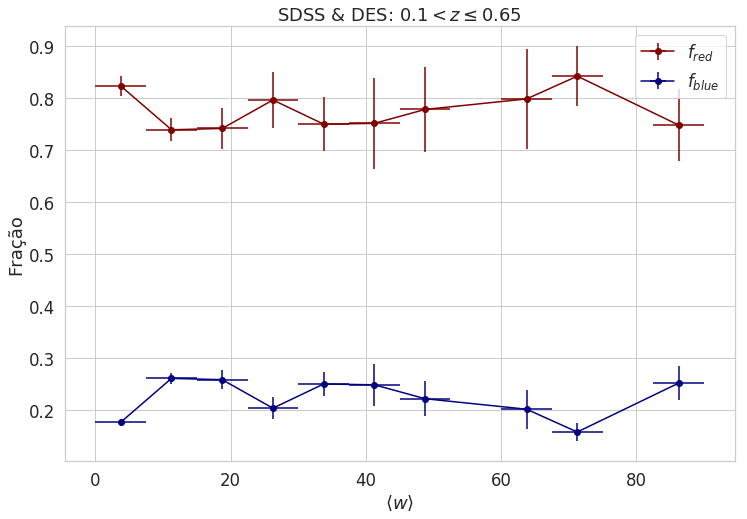

In [35]:
bin1 = (g['Pz']>0.3)&(g['Mr']<=-19.5)#&(g['Rnorm']<1/0.65)#&(g['z_cls']>0.35)
plotFraction2(g[bin1],title=r'SDSS & DES: $0.1 < z \leq 0.65$',bin_width=7.5,
             xlabel=r'$\left< w \right>$',label='Pztype_ri',col='w')
# plt.savefig('../rel_color.png')

### Evolução com Redshift

In [36]:
print('Aglomerados - AGNs:')
bin1 = (g['Pz']>0.1)&(g['Mr']<=-19.)&(g['Rnorm']<1/0.65)
gbin = g[bin1].group_by('z_cls')
ncls = len(cat)

cat['N_AGNs'] = 0
cat['richness'] = 0
count=0
for i in range(ncls):
    w, = np.where(cat['redshift'][i]==g[bin1]['z_cls'])
    group = g[w]
    nAGNs_per_cluster = np.count_nonzero(group['AGN'] == True)
    cat['N_AGNs'][i] = int(nAGNs_per_cluster)
    cat['richness'][i] = np.sum(group['Pmem'])
    if nAGNs_per_cluster<1:
        count += 1
#         print('{0}. {1}'.format(count,cat['Name'][i]))
        # cat['FLAG'] = True
print('Existem tantos aglomerados sem AGNs:',count)

Aglomerados - AGNs:
Existem tantos aglomerados sem AGNs: 76


In [41]:
def plotFractionZ(gc,bin_width=0.1,title=None,r_aper=1,label='type'):
    fred,fblue,Nred,Nblue,radii = fracaoRedBlue2(gc,bin_width=bin_width,
                                                 label=label,col='z_cls',r_aper=r_aper)
    erry_red, erry_blue = poissonError(Nred,Nblue)
    plt.figure(figsize=(12,8))
    plt.errorbar(radii,fblue,xerr=bin_width/2,yerr=erry_blue,marker='o',color='#000080',label=r'$f_{blue}$')
#     plt.xlim(0,radii.max()+bin_width/2)
    plt.legend()
    plt.ylabel('Fração')
    plt.xlabel(r'redshift')
#     plt.ylim(0.,1.)
    if title is not None:
        plt.title(title)
        


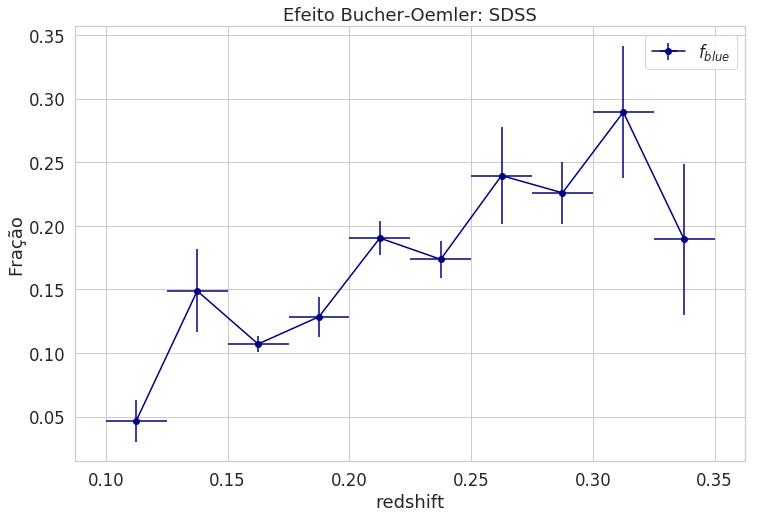

In [75]:
bin1 = (g['Pz']>0.3)&(g['mr']<=22.2)&(g['Mr']<=-19.)&(g['DES']==False)&(g['z_cls']<0.35)&(g['z_cls']>0.1)
plotFractionZ(g[bin1],bin_width=0.025,r_aper=1/0.65,
              title='Efeito Bucher-Oemler: SDSS',label='Pztype_ri')
# plt.savefig('../figure_5_Pz.png')
# plt.savefig('../figure_5_gr.png')

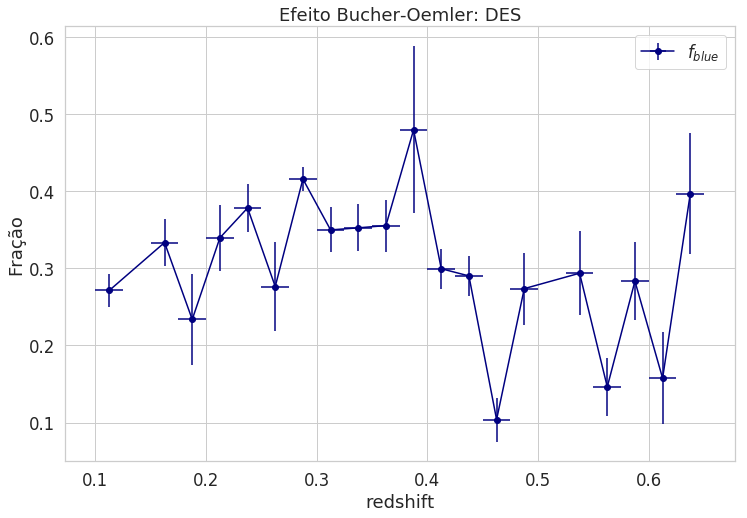

In [76]:
bin1 = (g['Pz']>0.3)&(g['mr']<=22.2)&(g['Mr']<=-19.)&(g['z_cls']<0.65)&(g['z_cls']>0.1)&(g['DES']==True)
plotFractionZ(g[bin1],bin_width=0.025,r_aper=1/0.65,
              title='Efeito Bucher-Oemler: DES',label='Pztype_ri')
# plt.savefig('../figure_5_Pz.png')
# plt.savefig('../figure_5_gr.png')

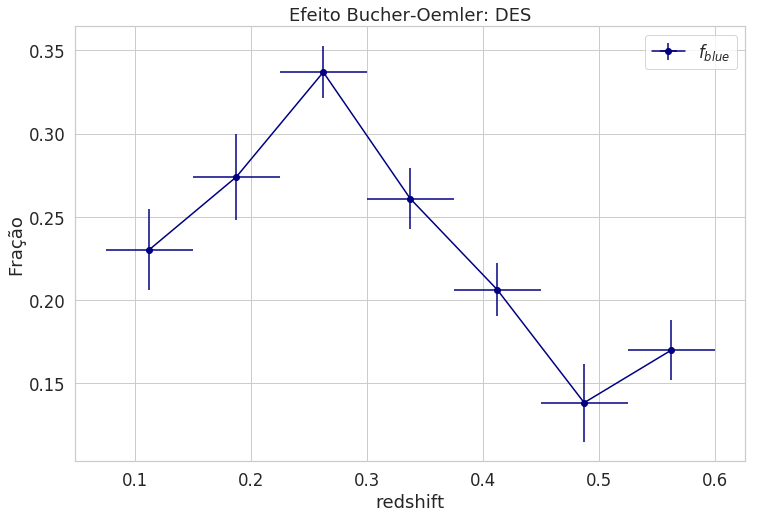

In [73]:
bin1 = (g['Pz']>0.3)&(g['Mr']<=-19.5)&(g['DES']==True)&(g['z_cls']<=0.6)&(g['z_cls']>0.1)
plotFractionZ(g[bin1],bin_width=0.075,r_aper=1,
              title='Efeito Bucher-Oemler: DES',label='Pztype_ri')
# plt.savefig('../figure_5_Pz.png')
# plt.savefig('../figure_5_gr.png')

In [40]:
g['M500'] = 0.
g['Mg500'] = 0.
g['kT'] = 0.
for i in range(len(cat)):
    cls_id, cls_z, M500, Mg500 = cat['redshift'][i],cat['redshift'][i],(cat['M500'][i]),cat['Mg500'][i]
    kT = cat['kT'][i]
    title = '%s'%(cat['Name'][i])

    galaxies = g[g['z_cls']==cls_id]
    maskAll, = np.where(g['z_cls'] == cls_id)
    g['M500'][maskAll] = M500
    g['Mg500'][maskAll] = Mg500
    g['kT'][maskAll] = kT

In [ ]:
def plotFractionM(gc,bin_width=0.1,title=None,label='type',r_aper=1):
    fred,fblue,Nred,Nblue,radii = fracaoRedBlue2(gc,bin_width=bin_width,
                                                 label=label,col='M500',r_aper=r_aper)
    
    erry_red, erry_blue = poissonError(Nred,Nblue)

    plt.figure(figsize=(12,8))
#     plt.errorbar(radii,fred,xerr=bin_width/2,yerr=erry_red,marker='o',color='#800000',label=r'$f_{red}$')
    plt.errorbar(radii,fblue,xerr=bin_width/2,yerr=erry_blue,marker='o',color='#000080',label=r'$f_{blue}$')
#     plt.xlim(0,radii.max()+bin_width/2)
    plt.legend()
    plt.ylabel('Fração')
    plt.xlabel(r'M$_{500}$')
#     plt.ylim(0.,1.)
    if title is not None:
        plt.title(title)
        
bin1 = (g['Pz']>0.3)&(g['Mr']<=-19.5)&(g['CC']==False)
plotFractionM(g[bin1],bin_width=2.5,
              label='Pztype_ri',r_aper=1/0.65)
plt.ylim(0.15,0.35)
# plt.axvline(0.36,linestyle='--',color='k')
# plt.axvline(0.17,linestyle='--',color='k')
# plt.savefig('../figure_5_Pz.png')

### Atividade Nuclear

In [55]:
def fracaoAGN(data,bin_width=0.25,bining='R'):
    radii = data[bining]

    ## bin
    rbin = np.trunc(radii/bin_width)
    data_bin = data.group_by(rbin)
    Npoints = rbin.max() 
    radii_bin = np.linspace(bin_width/2,(Npoints+1/2)*bin_width,Npoints+1)

    agn = data_bin['AGN'].groups.aggregate(np.count_nonzero)
    total = data_bin['Pmem'].groups.aggregate(np.sum)

    fagn = agn/total

    return fagn,agn,radii_bin
def fracaoAGN(data,bin_width=0.25,bining='Rnorm'):
    radii = data[bining]

    ## bin
    rbin = np.trunc(radii/bin_width)
    data_bin = data.group_by(rbin)
    Npoints = rbin.max() 
    radii_bin = np.linspace(bin_width/2,(Npoints+1/2)*bin_width,Npoints+1)

    agn = data_bin['AGN'].groups.aggregate(np.count_nonzero)
    total = data_bin['Pmem'].groups.aggregate(np.sum)

    fagn = agn/total

    return fagn,agn,radii_bin
def poissonErrorAGN(N_AGN,NTotal):
    A = ( np.sqrt(N_AGN)/(NTotal) + N_AGN/(NTotal)**(3/2))
    return A

def plotFractionAGN(gc,bin_width=0.1,bining='R',title=None):
    fagn,agn,radii = fracaoAGN(gc,bin_width=bin_width,bining=bining)
    fagn = fagn/fagn.max()
    
    err = poissonErrorAGN(agn,agn/fagn)
    err = np.where(err<0.01,0.01,err)
    plt.figure(figsize=(11,9.5))
    plt.errorbar(radii,fagn,xerr=bin_width/2,yerr=err,marker='o',color='#6C3483')
    plt.fill_between(radii, fagn-err, fagn+err,color='#BB8FCE',alpha=0.6)
    
    plt.ylabel('Contagem Normalizada de AGNs')
    plt.xlabel(r'Projected r (Mpc)')
#     plt.xlim(0,6)
#     plt.ylim(0.,1.1)
    if title is not None:
        plt.title(title)

def plotFractionAGN2(gc,bin_width=0.25,title=None,label='type'):
    fred,fblue,Nred,Nblue,radii = fracao(gc,bin_width=bin_width,label=label)
    
    erry_red, erry_blue = poissonError(Nred,Nblue)
#     erry_red, erry_blue = 0.01,0.01

    plt.axvline(1/0.65,linestyle='--',color='k',label=r'$R_{200,c}$')
    plt.errorbar(radii,fred,xerr=bin_width/2,yerr=erry_red,marker='o',color='#800000',label=r'$f_{AGN,red}$')
    plt.errorbar(radii,fblue,xerr=bin_width/2,yerr=erry_blue,marker='o',color='#000080',label=r'$f_{AGN,blue}$')
#     plt.xlim(0,radii.max()+bin_width/2)
    plt.legend()
    plt.ylabel('Frequencia')
#     plt.xlabel(r'$R \; [Mpc]$')
    plt.xlabel(r'$R/R_{500}$')
    plt.ylim(0.,1.)
    if title is not None:
        plt.title(title)

# agns 967


/home/johnny/run/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


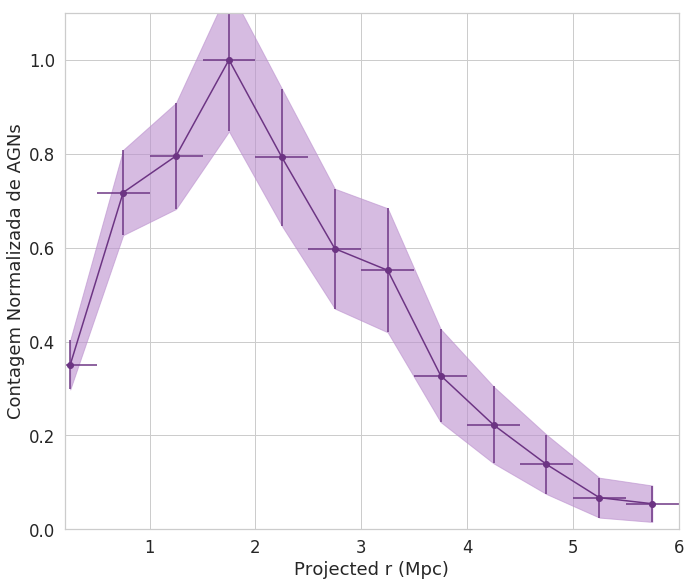

In [56]:
sns.set_style("whitegrid")
bin1 =(g['Pz']>0.1)&(g['Mr']<=-19.5)&(g['R']<=6)
print('# agns',np.count_nonzero((g['Pz']>0.1)&(g['Mr']<=-19.5)&(g['AGN']==True)))
plotFractionAGN(g[bin1],bin_width=0.5)
plt.xlim(0.2,6)
plt.ylim(0,1.1)
plt.savefig('../figure_6.png', transparent=True)

# agns 60


/home/johnny/run/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/home/johnny/run/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/johnny/run/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


# agns 560
# agns 359
# agns 208


(0.0, 1.1)

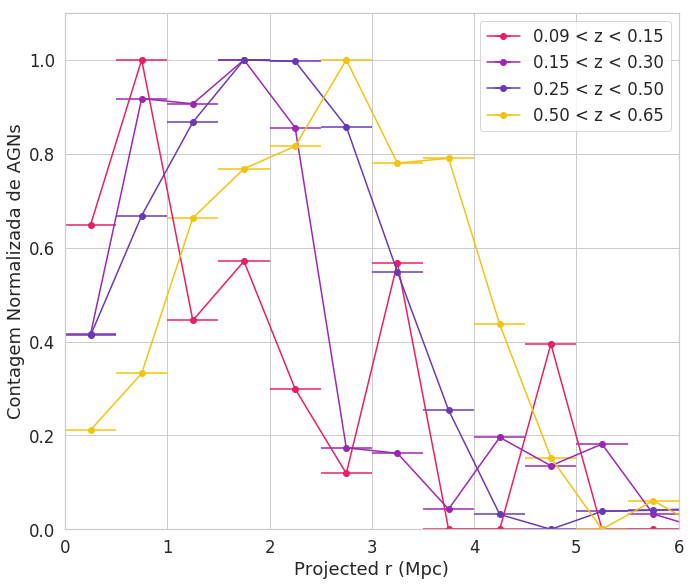

In [58]:
sns.set_style("whitegrid")

zbin=[[0.09,0.15],[0.15,0.3],[0.25,0.5],[0.5,0.65]]
colors=['#E91E63','#9C27B0','#673AB7','#F1C40F']
# gbins=[g[bin0],g[bin1],g[bin2],g[bin3]]

plt.figure(figsize=(11,9.5))
for cs,zb in zip(colors,zbin):
    bin1 =(g['Pz']>0.1)&(g['Mr']<=-19.)&(g['z_cls']>zb[0])&(g['z_cls']<zb[1])
    print('# agns',np.count_nonzero((g['Pz']>0.1)&(g['Mr']<=-19.)&(g['z_cls']>zb[0])&(g['z_cls']<zb[1])&(g['AGN']==True)))
    fagn,agn,radii = fracaoAGN(g[bin1],bin_width=bin_width,bining='R')
    fagn = fagn/fagn.max()

    err = poissonErrorAGN(agn,agn/fagn)
    err = np.where(err<0.01,0.01,err)
    plt.errorbar(radii,fagn,xerr=bin_width/2,marker='o',color=cs,label='%.2f < z < %.2f'%(zb[0],zb[1]))
#     plt.fill_between(radii, fagn-err, fagn+err,color='#BB8FCE',alpha=0.6)
plt.legend()
plt.ylabel('Contagem Normalizada de AGNs')
plt.xlabel(r'Projected r (Mpc)')
plt.xlim(0,6)
plt.ylim(0.,1.1)
# plt.savefig('../figure_7.png', transparent=True)

# agns 967


/home/johnny/run/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


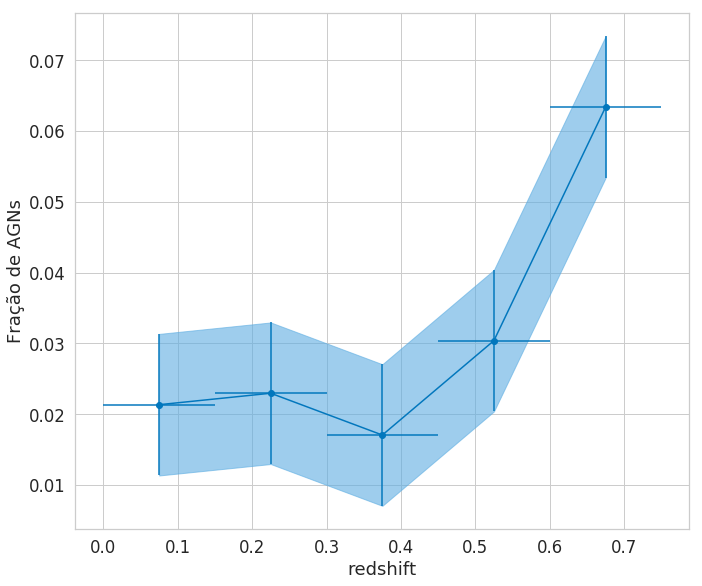

In [59]:
sns.set_style("whitegrid")
def plotFractionAGN(gc,bin_width=0.1,bining='R',title=None,xlabel=r'redshift'):
    fagn,agn,radii = fracaoAGN(gc,bin_width=bin_width,bining=bining)
#     fagn = fagn/fagn.max()
    
    err = poissonErrorAGN(agn,agn/fagn)
    err = np.where(err<0.01,0.01,err)
    plt.figure(figsize=(11,9.5))
    plt.errorbar(radii,fagn,xerr=bin_width/2,yerr=err,marker='o',color='#0277BD')
    plt.fill_between(radii, fagn-err, fagn+err,color='#5DADE2',alpha=0.6)
    
    plt.ylabel('Fração de AGNs')
    plt.xlabel(xlabel)
#     plt.xlim(0,6)
#     plt.ylim(0.,1.1)
    if title is not None:
        plt.title(title)
        
bin1 =(g['Pz']>0.1)&(g['Mr']<=-19.5)#&(g['Rel']==True)
print('# agns',np.count_nonzero((g['Pz']>0.1)&(g['Mr']<=-19.5)&(g['AGN']==True)))
plotFractionAGN(g[bin1],bin_width=0.15,bining='z_cls')
plt.savefig('../figure_fAGNs_z.png', transparent=True)

# agns 372


/home/johnny/run/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


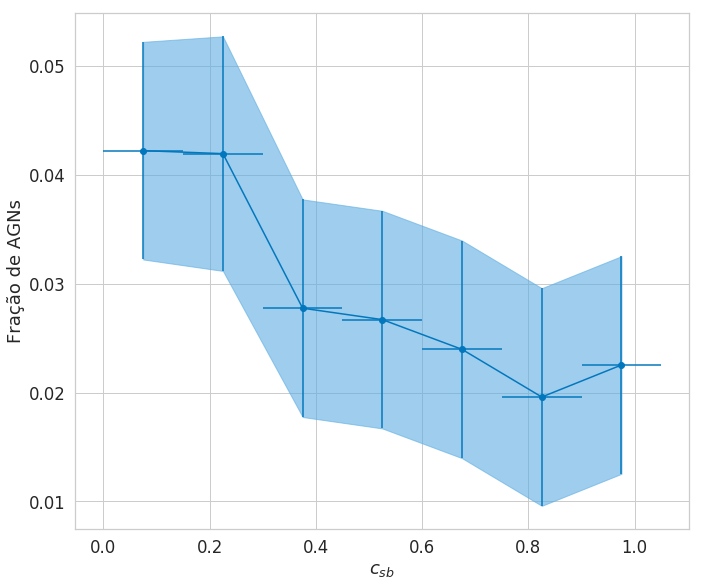

In [60]:
bin1 =(g['Pz']>0.1)&(g['Mr']<=-19.5)&(g['Rnorm']<1)
print('# agns',np.count_nonzero((g['Pz']>0.1)&(g['Mr']<=-19.5)&(g['Rnorm']<1)&(g['AGN']==True)))
plotFractionAGN(g[bin1],bin_width=.15,bining='csb',xlabel=r'$c_{sb}$')
plt.savefig('../figure_fAGNs_coolCore.png', transparent=True)

# agns 967


/home/johnny/run/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


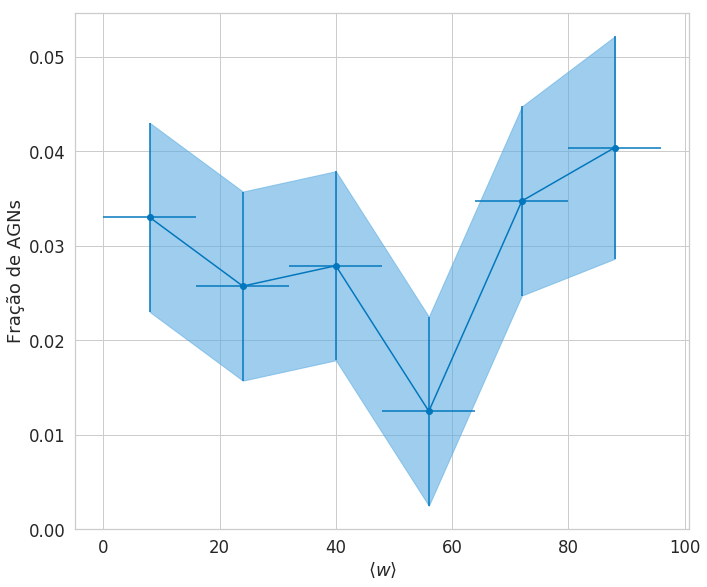

In [61]:
bin1 =(g['Pz']>0.1)&(g['Mr']<=-19.5)&(g['Rnorm']<1/0.65)
print('# agns',np.count_nonzero((g['Pz']>0.1)&(g['Mr']<=-19.5)&(g['AGN']==True)))
plotFractionAGN(g[bin1],bin_width=16,bining='w',xlabel=r'$\left< w \right>$')
plt.savefig('../figure_fAGNs_Nrel.png', transparent=True)

# agns 967


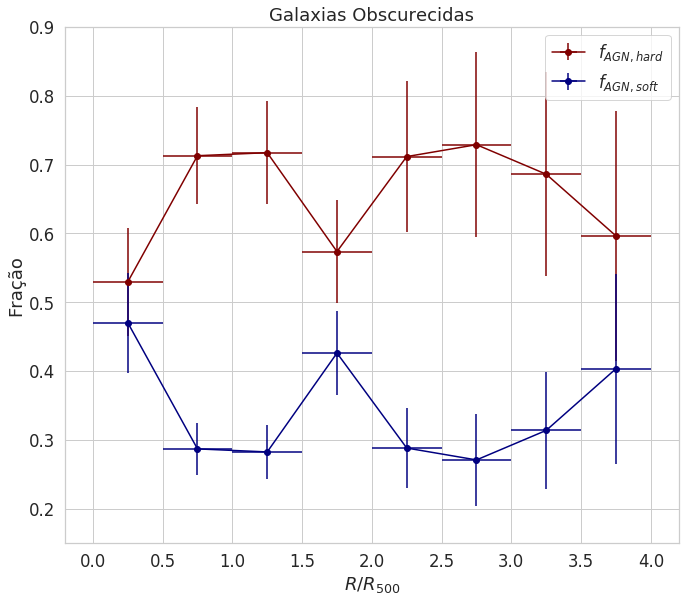

In [66]:
def plotFractionAGN2(gc,bin_width=0.25,title=None,label='type'):
    fred,fblue,Nred,Nblue,radii = fracaoRedBlue(gc,bin_width=bin_width,label=label,col='Rnorm')
    
    plt.figure(figsize=(11,9.5))
    erry_red, erry_blue = poissonError(Nred,Nblue)
#     erry_red, erry_blue = 0.01,0.01

#     plt.axvline(1/0.65,linestyle='--',color='k',label=r'$R_{200,c}$')
    plt.errorbar(radii,fred,xerr=bin_width/2,yerr=erry_red,marker='o',
                 color='#800000',label=r'$f_{AGN,hard}$')
    plt.errorbar(radii,fblue,xerr=bin_width/2,yerr=erry_blue,
                 marker='o',color='#000080',label=r'$f_{AGN,soft}$')
#     plt.xlim(0,radii.max()+bin_width/2)
    plt.legend()
    plt.ylabel('Fração')
#     plt.xlabel(r'$R \; [Mpc]$')
    plt.xlabel(r'$R/R_{500}$')
    plt.ylim(0.15,.9)
    if title is not None:
        plt.title(title)

bin1 =(g['Pz']>0.1)&(g['Mr']<=-19.5)&(g['Rnorm']<4.)#&(g['CC']==True)
print('# agns',np.count_nonzero((g['Pz']>0.1)&(g['Mr']<=-19.5)&(g['AGN']==True)))
plotFractionAGN2(g[bin1],bin_width=0.5,label='Obscured',title='Galaxias Obscurecidas')
plt.savefig('../figure_fAGNs_Obsc.png',transparent=True)

# galaxias 1073
# Aglomerados 94


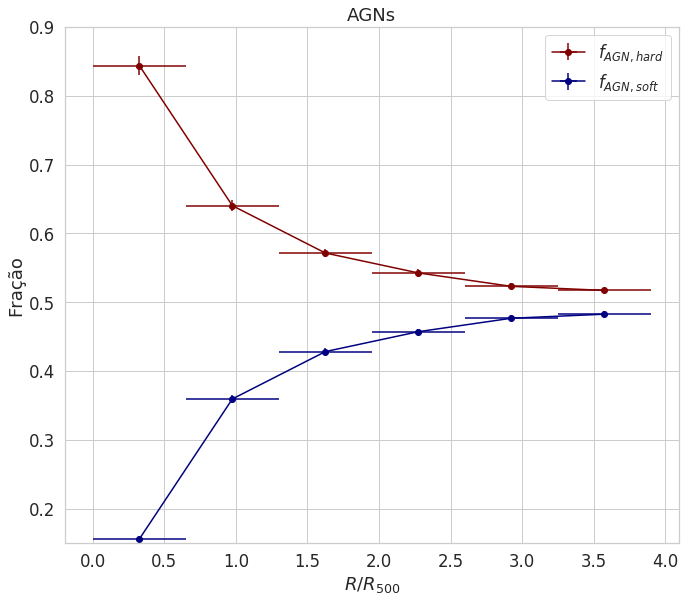

In [68]:
bin1 =(g['Pz']>0.1)&(g['Mr']<=-19.)&(g['AGN']==True)
print('# galaxias',np.count_nonzero(bin1))
print('# Aglomerados',len(np.unique(g[bin1]['Name'])))
plotFractionAGN2(g[bin1],title=r'AGNs',bin_width=0.65,label='type_ri')
plt.savefig('../figure_7.png')

# galaxias 967
# Aglomerados 93


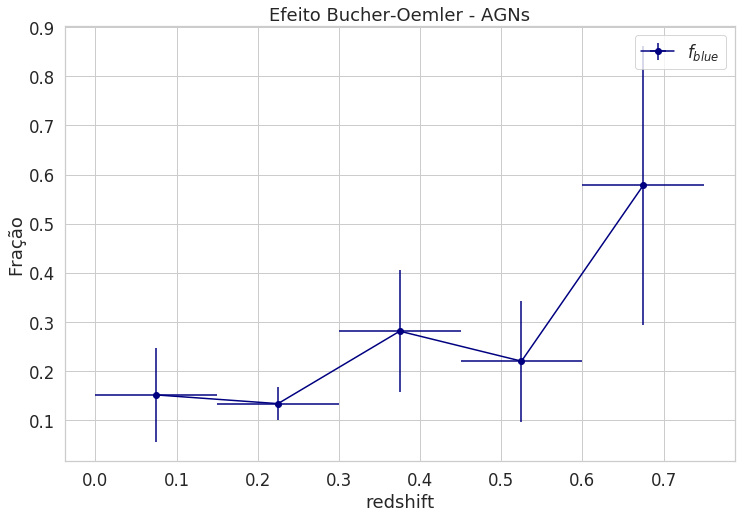

In [76]:
bin1 =(g['Pz']>0.1)&(g['Mr']<=-19.5)&(g['AGN']==True)#&(g['Rnorm']<1/0.65)
print('# galaxias',np.count_nonzero(bin1))
print('# Aglomerados',len(np.unique(g[bin1]['Name'])))
plotFractionZ(g[bin1],bin_width=0.15,title='Efeito Bucher-Oemler - AGNs',label='type_ri')
# plt.savefig('../figure_8.png')

# galaxias 967
# Aglomerados 93


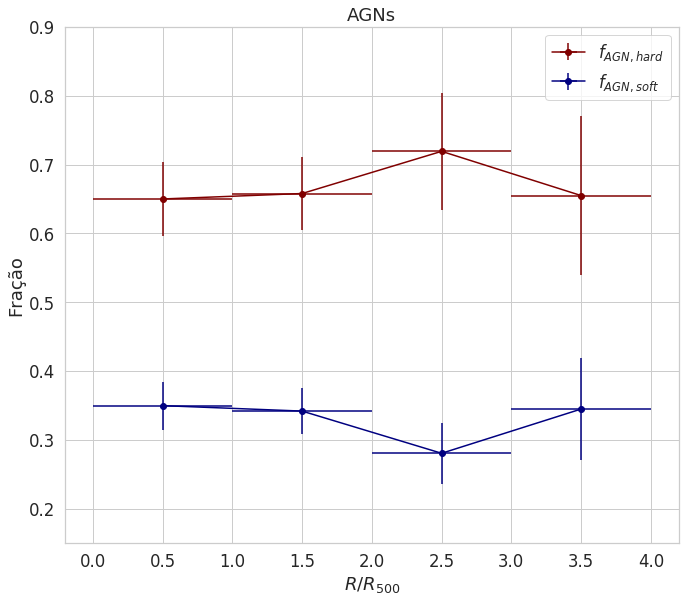

In [77]:
bin1 =(g['Pz']>0.1)&(g['Mr']<=-19.5)&(g['AGN']==True)
print('# galaxias',np.count_nonzero(bin1))
print('# Aglomerados',len(np.unique(g[bin1]['Name'])))
plotFractionAGN2(g[bin1],title=r'AGNs',bin_width=1,label='Obscured')
# plt.savefig('../figure_7.png')

In [78]:
def fracaoAGN(data,bin_width=0.25):
    radii = data['M500']

    ## bin
    rbin = np.trunc(radii/bin_width)
    data_bin = data.group_by(rbin)
    Npoints = rbin.max() 
    radii_bin = np.linspace(bin_width/2,(Npoints+1/2)*bin_width,Npoints+1)

    agn = data_bin['AGN'].groups.aggregate(np.count_nonzero)
    total = data_bin['Pmem'].groups.aggregate(np.sum)

    fagn = agn/total

    return fagn,agn,radii_bin

def poissonErrorAGN(N_AGN,NTotal):
    A = ( np.sqrt(N_AGN)/(NTotal) + N_AGN/(NTotal)**(3/2))
    return A

def plotFractionAGN(gc,bin_width=0.1,title=None):
    fagn,agn,radii = fracaoAGN(gc,bin_width=bin_width)
    
    err = poissonErrorAGN(agn,agn/fagn)
    
    plt.figure(figsize=(12,8))
#     plt.axvline(1/0.65,linestyle='--',color='k',label=r'$R_{200,c}$')
    plt.errorbar(radii,fagn,xerr=bin_width/2,yerr=err,marker='o',color='#000080')
#     plt.xlim(0,radii.max()+bin_width/2)
    plt.legend()
    plt.ylabel('Fração')
    plt.xlabel(r'$M_{gas} \;[ 10^{13}\,M_{\odot}]$')
#     plt.xlabel(r'M$_{500} \;[ 10^{14}\,M_{\odot}]$')
#     plt.xlabel(r'$f_{barions}$')
#     plt.ylim(0.,1.)
    if title is not None:
        plt.title(title)

def plotFractionAGN2(gc,gc2,bin_width=2.5,lbl1='bla',lbl2='bla',title=None):
    fagn,agn,radii1 = fracaoAGN(gc,bin_width=bin_width)
    fagn2,agn2,radii2 = fracaoAGN(gc2,bin_width=bin_width)
    
    err = poissonErrorAGN(agn,agn/fagn)
    err2 = poissonErrorAGN(agn2,agn2/fagn2)
    
    plt.figure(figsize=(12,8))
    plt.errorbar(radii1,fagn,xerr=bin_width/2,yerr=err,marker='o',color='#800000',label='%s'%(lbl1))
    plt.errorbar(radii2,fagn2,xerr=bin_width/2,yerr=err,marker='o',color='#000080',label='%s'%(lbl2))
    plt.legend()
    plt.ylabel('Fração')
#     plt.xlabel(r'$M_{gas} \;[ 10^{13}\,M_{\odot}]$')
    plt.xlabel(r'M$_{500} \;[ 10^{14}\,M_{\odot}]$')
#     plt.ylim(0.,1.)
    if title is not None:
        plt.title(title)


In [79]:
mask = (cat['N_AGNs'] > 0 )

id_cut_gal = getIDX(g,cat['redshift'][mask])
gc = g[id_cut_gal]

# agns 396


/home/johnny/run/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  
/home/johnny/run/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


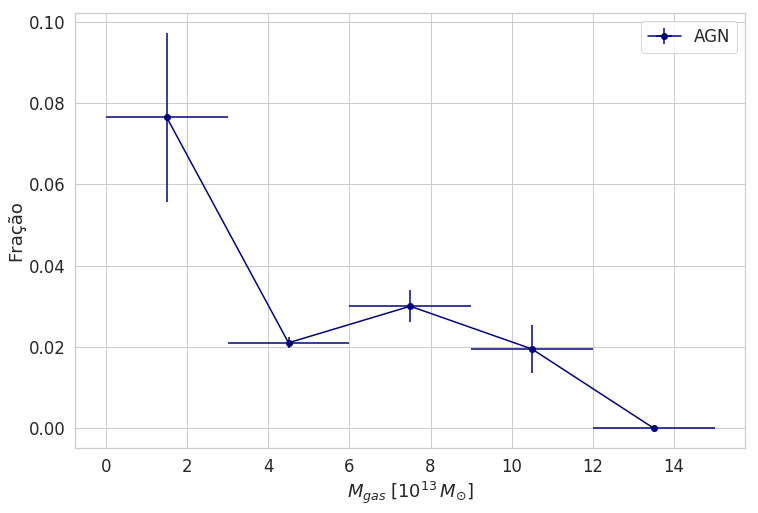

In [80]:
bin1 =(gc['Pz']>0.01)&(gc['Mr']<=-19.)&(gc['Rnorm']<4)&(gc['M500']<15)
print('# agns',np.count_nonzero((gc['Pz']>0.1)&(gc['Mr']<=-19.)&(gc['AGN']==True)))
plotFractionAGN(gc[bin1],bin_width=3,title=None)
# plt.savefig('../figure_9.png')

# agns 967


/home/johnny/run/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


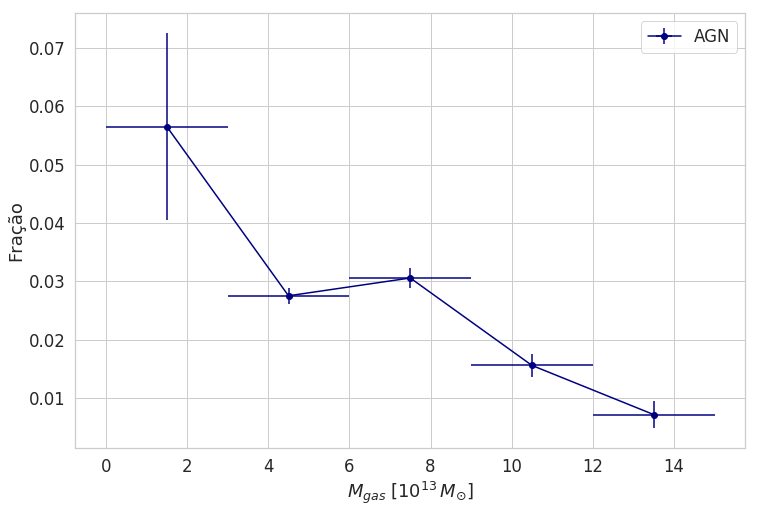

In [81]:
bin1 =(g['Pz']>0.1)&(g['Mr']<=-19.)&(g['Rnorm']<4)&(g['M500']<15)
print('# agns',np.count_nonzero((g['Pz']>0.1)&(g['Mr']<=-19.5)&(g['AGN']==True)))
plotFractionAGN(g[bin1],bin_width=3.,title=None)
# plt.savefig('../figure_10.png')

# agns 190055
# Aglomerados 49


/home/johnny/run/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


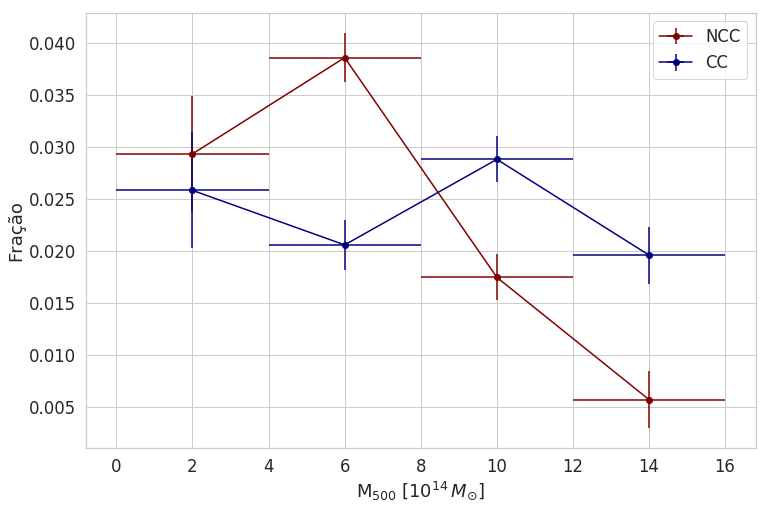

In [205]:
bin1 =(g['Pz']>0.1)&(g['Mr']<=-19.)&(g['Rnorm']<4)&(g['M500']>1)&(g['CC']==False)
bin2 =(g['Pz']>0.1)&(g['Mr']<=-19.)&(g['Rnorm']<4)&(g['M500']>1)&(g['CC']==True)
print('# agns',np.count_nonzero(bin2) )
print('# Aglomerados',len(np.unique(g[bin2]['Name'])))
plotFractionAGN2(g[bin1],g[bin2],bin_width=4.,lbl1='NCC',lbl2='CC',title=None)
# plt.savefig('../figure_12.png')

In [164]:
bin1 =(g['Pz']>0.1)&(g['Mr']<=-19.5)&(g['Rnorm']<4)&(g['M500']>1)&(g['Rel']==False)
bin2 =(g['Pz']>0.1)&(g['Mr']<=-19.5)&(g['Rnorm']<4)&(g['M500']>1)&(g['Rel']==True)
print('# agns',np.count_nonzero(bin2) )

plotFractionAGN2(g[bin1],g[bin2],bin_width=4.,lbl1='NRel',lbl2='Rel',title=None)
# plt.savefig('../figure_13.png')

# agns 109836


KeyError: 'fb'

In [165]:
cat[cat['M500']>15]['Name','Mg500']

Name,Mg500
str16,float32
RM-43,26.71


In [166]:
cat['fb'] = 1.06*cat['Mg500']/(cat['M500']*10)
g['fb'] = 1.16*g['Mg500']/(g['M500']*10)

# agns 801


/home/johnny/run/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


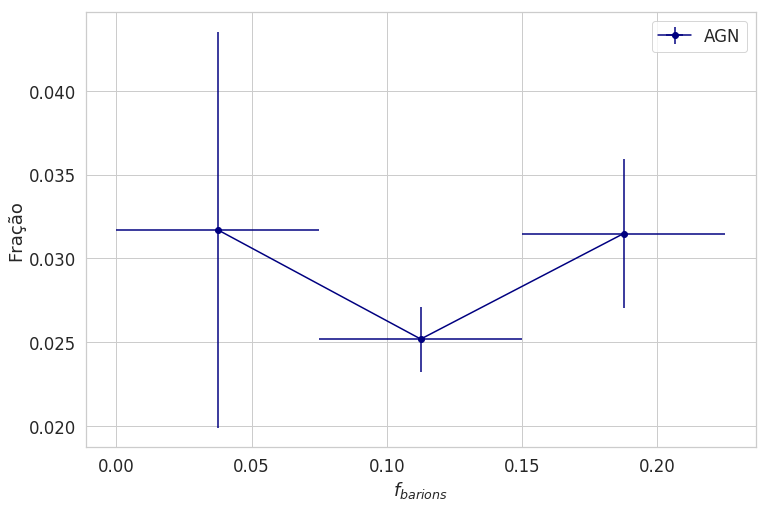

In [167]:
bin1 =(g['Pz']>0.1)&(g['Mr']<=-19.5)&(g['Rnorm']<1)&(g['M500']>1)#&(g['CC']==False)
print('# agns',np.count_nonzero((g['Pz']>0.1)&(g['Mr']<=-19.5)&(g['AGN']==True)))
plotFractionAGN(g[bin1],bin_width=0.075,title=None)
plt.savefig('../figure_11.png')

## Subtração do Background 

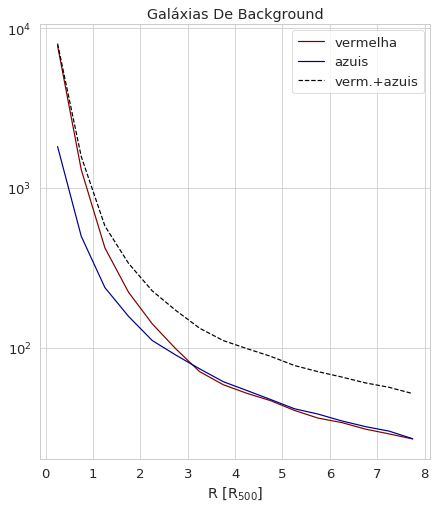

In [106]:
## Agrupar por 0.5 R500
bin_width = 0.5
col,label = 'Rnorm', 'type_ri'

bin2 = (g['Pz']>0.3)&(g['Mr']<=-19.5)
bin1 = np.trunc(g[col][bin2]/bin_width)
data_bin = g[bin2].group_by(bin1)

xbin = (data_bin.groups.keys+1/2)*bin_width ## xbins
area = np.pi*(data_bin['R'].groups.aggregate(np.median))

red_plus_blue = data_bin[label].groups.aggregate(np.count_nonzero)
red_minus_blue = data_bin[label].groups.aggregate(np.sum)

red = (red_plus_blue+red_minus_blue)/2
blue = (red_plus_blue-red_minus_blue)/2

bkg_mask = xbin>=5
red_bkg = red[bkg_mask].sum()
blue_bkg = blue[bkg_mask].sum()

area_per_bin = np.pi*(xbin[1]-xbin[0])**2
area_bkg = np.pi*(np.max(xbin[bkg_mask])**2-np.min(xbin[bkg_mask])**2)
gamma = area_per_bin/area_bkg

red_net = red-gamma*red_bkg
blue_net = blue-gamma*blue_bkg
Total = red_net+blue_net

fred = red_net/Total
fblue = blue_net/Total
plt.figure(figsize=(7,8))
plt.plot(xbin,red/(area)**2,color='#800000',label='vermelha')
plt.plot(xbin,blue/(area)**2,color='#00008B',label='azuis')
plt.plot(xbin,Total/(area)**2,color='k',linestyle='--',label='verm.+azuis')
plt.yscale('log')
# plt.xscale('log')
plt.xlabel(r'R [R$_{500}]$')
plt.title('Galáxias De Background')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend()
plt.savefig('background')

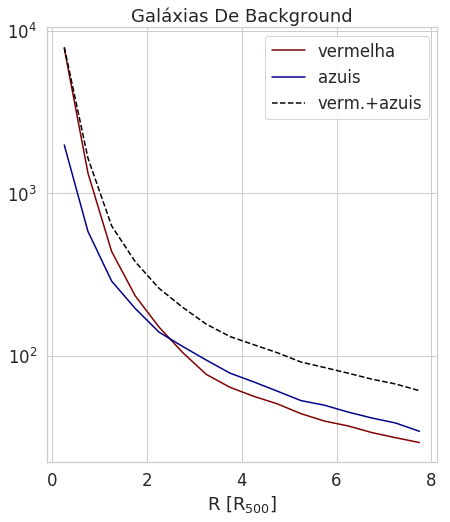

In [22]:

plt.figure(figsize=(7,8))
plt.plot(xbin,red/(area)**2,color='#800000',label='vermelha')
plt.plot(xbin,blue/(area)**2,color='#00008B',label='azuis')
plt.plot(xbin,Total/(area)**2,color='k',linestyle='--',label='verm.+azuis')
plt.yscale('log')
# plt.xscale('log')
plt.xlabel(r'R [R$_{500}]$')
plt.title('Galáxias De Background')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend()
plt.savefig('background')

In [9]:
def doColorSubtraction(data,col='r-i',bin_widht=0.02,r_aper=1/0.65,crange=(-1.,3.)):
    minColor, maxColor = crange
    gm,gb = data[data['Rnorm']<=r_aper],data[data['Rnorm']>=4]
    r_out = np.max(data['Rnorm'])

    bin1 = np.trunc(gm[col]/bin_width)
    data_bin = gm.group_by(bin1)

    xbin = (data_bin.groups.keys+1/2)*bin_width ## xbins
    total = data_bin['Pz'].groups.aggregate(np.sum)

    ## Background Subtraction
    area_per_bin = np.pi*(r_aper)**2
    area_bkg = np.pi*(r_out**2-4**2)
    gamma = area_per_bin/area_bkg

    bin_bkg = np.trunc(gb[col]/bin_width)
    data_bin_bkg = gb.group_by(bin_bkg)
    bkg = data_bin_bkg['Pz'].groups.aggregate(np.sum)
    xbin_bkg = (data_bin_bkg.groups.keys+1/2)*bin_width ## xbins

    colorbin = np.arange(minColor,maxColor,bin_width/2)
    Ntotal = np.interp(colorbin,xbin,total)
    Nbkg = np.interp(colorbin,xbin_bkg,bkg)
    Net = Ntotal-gamma*Nbkg

    Net = np.where(Net<0,0,Net)
    
    return colorbin,Net,Ntotal,Nbkg,gamma

def doColorModel(data,col='r-i',r_aper=4,mean_color=1.,sigma=0.3):
    x,Net,Ntotal,Nbkg,gamma = doColorSubtraction(data,col='r-i',bin_widht=0.06,
                       r_aper=4,crange=(-1.,2.))

    cut = (x>x[np.argmax(Net)]-7*sigma)&(x<x[np.argmax(Net)]+5*sigma)

    col3,weights3,paramColorModel = gM.gmmMain_doFit(x[cut],weights=Net[cut],
                                                     mean=mean_color,HandleError=False)
    mur,mub,sigr,sigb,alphar,alphab,conv = paramColorModel
    
    return paramColorModel,x,Net,Nbkg,gamma

def doColorProbabilities(params,color,Net,Nbkg,gamma):
    mur,mub,sigr,sigb,alphar,alphab,conv = params
    
    if conv:
        Lred = stats.norm.pdf(color,mur,sigr)*alphar
        Lblue = stats.norm.pdf(color,mub,sigb)*alphab

        Norm = np.interp(color,x,Net)
        Nbkgl = np.interp(color,x,Nbkg)

        Pred = Norm*Lred/(Norm*Lred+gamma*Nbkgl)
        Pblue = Norm*Lblue/(Norm*Lred+gamma*Nbkgl)
        Pc = (Norm*(Lred+Lblue))/(Norm*(Lred+Lblue)+gamma*Nbkgl)
    else:
        Pc, Pred, Pblue = (-99.)*np.ones_like(color),(-99.)*np.ones_like(color),(-99.)*np.ones_like(color)
        
    return Pc,Pred,Pblue

def plotColorSubtraction(params,c,Net,Ntotal,Nbkg,gamma,name='RM'):
    mur,mub,sigr,sigb,alphar,alphab,conv = params
    norm = sum(Net)*0.02
    
    plt.clf()
    plt.plot(c,Net)
    plt.fill_between(x,0,Net,alpha=0.2,color='#808B96',facecolor='#808B96')
    if conv:
        plt.plot(x,norm*stats.norm.pdf(x,mur,sigr)*alphar,color='r',linestyle="--")
        plt.plot(x,norm*stats.norm.pdf(x,mub,sigb)*alphab,color='b',linestyle="--")
        plt.xlim(mub-3*sigb,mur+3*sigr+0.1)
    plt.savefig('%s_color_model.png'%(name))

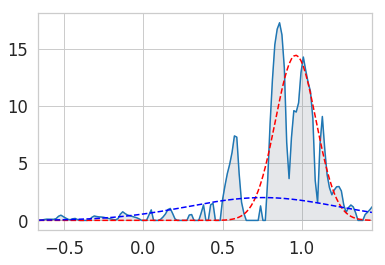

In [235]:
col = 'g-r'
r_aper = 1
bin_width = 0.03
bin1 =(g['DES']==True)&(g['Mr']<=-19.5)&(g['Rnorm']<6)

gg = g[bin1].group_by('z_cls')
ncls = len(gg.groups)
for i in range(ncls):
    data = gg.groups[i]
    title = 'RM-{}'.format(data['MEM_MATCH_ID'][0])
    mean_color = np.mean(data[data['type_gr']==1][col])
    sigma = np.std(data[data['type_gr']==1][col])
    paramColorModel,x,Net,Nbkg,gamma = doColorModel(data,col=col,r_aper=1,
                                                    mean_color=mean_color,sigma=sigma)

    Pc,Pr,Pb = doColorProbabilities(paramColorModel,x,Net,Nbkg,gamma)
    
    Ntotal = Net+gamma*Nbkg
#     plotColorSubtraction(paramColorModel,x,Net,Ntotal,Nbkg,gamma=gamma,name=title)

(-0.3, 1.5)

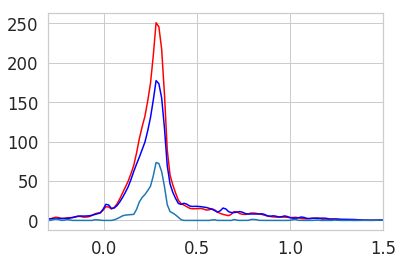

In [10]:
col = 'r-i'
r_aper = 1
bin_width = 0.03
bin1 =(g['DES']==True)&(g['Mr']<=-19.5)&(g['Rnorm']<6)

gg = g[bin1].group_by('z_cls')
data = gg.groups[10]
mean_color = np.mean(data[data['type_ri']==1]['r-i'])
sigma = np.std(data[data['type_ri']==1]['r-i'])

x,Net,Ntotal,Nbkg,gamma = doColorSubtraction(data,col='i-z',bin_widht=0.01,
                   r_aper=4,crange=(-2.,2.))

plt.plot(x,Ntotal,color='r')
plt.plot(x,gamma*Nbkg,color='b')
plt.plot(x,Net)
plt.xlim(-0.3,1.5)

In [11]:
import gmmModule as gM

cut = (x>x[np.argmax(Net)]-2*0.3)&(x<x[np.argmax(Net)]+0.7)

col3,weights3,paramColorModel = gM.gmmMain_doFit(x[cut],weights=Net[cut],
                                                 mean=0.35,HandleError=True)

mur,mub,sigr,sigb,alphar,alphab,conv = paramColorModel

Using Modified sklearn.mixture.GMM, modified to allow data weights


In [12]:
mean_color = np.mean(data[data['type_ri']==1]['r-i'])
sigma = np.std(data[data['type_ri']==1]['r-i'])
print('mean: %.2f \t sig: %.2f'%(mean_color,sigma))

mean: 0.42 	 sig: 0.04


(-0.15, 0.7)

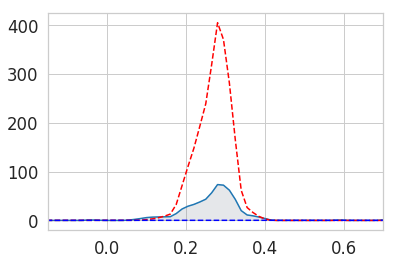

In [13]:
plt.plot(col3,weights3)
norm = sum(weights3)/len(weights3)
# plt.plot(col3,norm*stats.norm.pdf(col3,mur,sigr)*alphar,color='r',linestyle="--")
plt.fill_between(x,0,Net,alpha=0.2,color='#808B96',facecolor='#808B96')
plt.plot(x,Net*stats.norm.pdf(x,mur,sigr)*alphar,color='r',linestyle="--")
plt.plot(x,norm*stats.norm.pdf(x,mub,sigb)*alphab,color='b',linestyle="--")
plt.xlim(-0.5,1)

# plt.plot(x,Ntotal,color='r')
# plt.plot(x,gamma*Nbkg,color='b')
# plt.plot(x,Net)
plt.xlim(-0.15,.7)

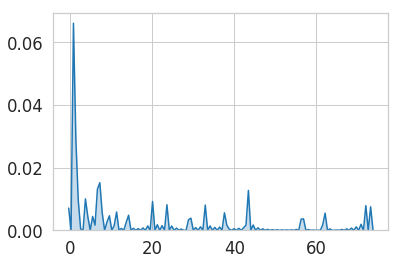

In [14]:
sns.kdeplot(Net, shade=True);

In [15]:
colorbin = data['r-i']

Ntotal = np.interp(colorbin,x,Net)

In [16]:
colorbin = np.sort(np.array(colorbin[:]))
Lred = stats.norm.pdf(colorbin,mur,sigr)*alphar
Lblue = stats.norm.pdf(colorbin,mub,sigb)*alphab

Norm = np.interp(colorbin,x,Net)
Nbkgl = np.interp(colorbin,x,Nbkg)

Pred = Norm*Lred/(Norm*Lred+gamma*Nbkgl)
Pblue = Norm*Lblue/(Norm*Lred+gamma*Nbkgl)
Pc = (Norm*(Lred+Lblue))/(Norm*(Lred+Lblue)+gamma*Nbkgl)

(-0.5, 1)

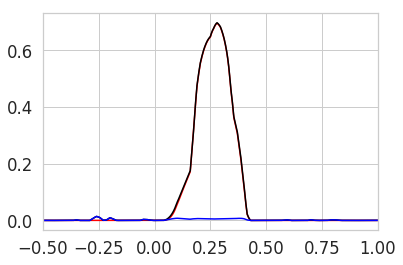

In [17]:
plt.plot(colorbin,Pred,'r')
plt.plot(colorbin,Pc,'k')
plt.plot(colorbin,Pblue,'b')
# plt.scatter(x,Net)
# plt.plot(col3,norm*stats.norm.pdf(col3,mur,sigr),color='r',linestyle="--")
# plt.plot(col3,norm*stats.norm.pdf(col3,mub,sigb),color='b',linestyle="--")
plt.xlim(-0.5,1)

In [18]:
gM.doPlot_colorModel_bg(color,color_bg,Pr[galMask],Pb[galMask],Pc[galMask],pmem,
                        scale_bg,pmem_bg,param0,kappa,
                        cls_z,22,expred,
                        labelx=labely1,name=title)

NameError: name 'color_bg' is not defined

In [19]:
np.unique(data['MEM_MATCH_ID','z_cls'])

array([(87, 0.222)], dtype=[('MEM_MATCH_ID', '<i4'), ('z_cls', '<f8')])